In [1]:
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz


--2025-03-24 22:39:56--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz [following]
--2025-03-24 22:39:58--  https://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18384171 (18M)
Saving to: ‘kmnist-train-imgs.npz.1’

kmnist-train-imgs.n  10%[=>                  ]   1.85M   438KB/s    eta 37s    ^C
--2025-03-24 22:40:04--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sen

In [32]:
import numpy as np
from sklearn.manifold import Isomap, TSNE, SpectralEmbedding
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def load(f):
    return np.load(f)['arr_0']

x_train = load('kmnist-train-imgs.npz')
x_test = load('kmnist-test-imgs.npz')
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

x_train = x_train / 255.0
x_test = x_test / 255.0
print(x_train.shape, x_test.shape)


(60000, 784) (10000, 784)


In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

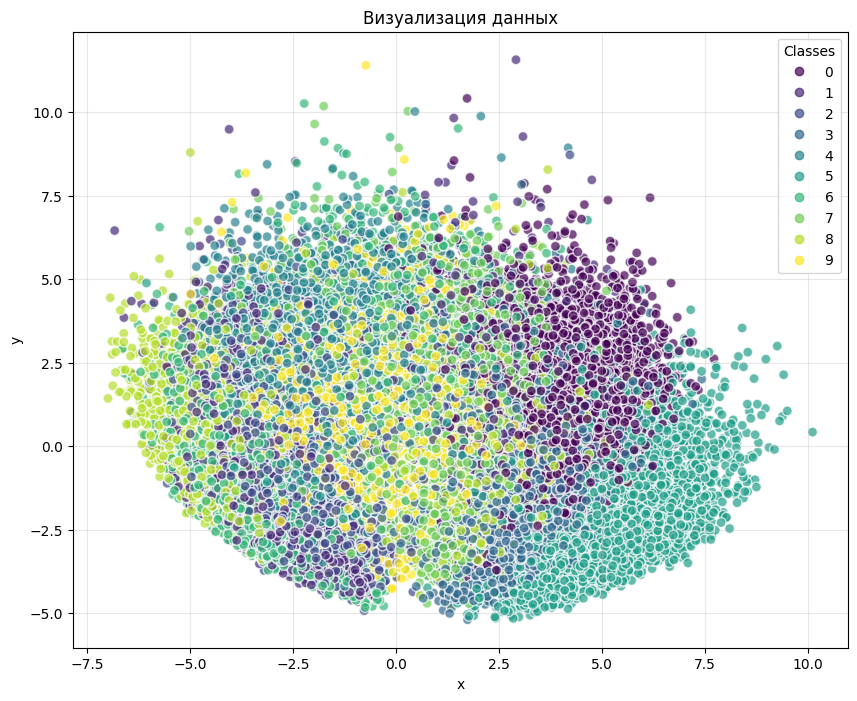

In [35]:
low_dim_train = PCA(n_components=2).fit_transform(x_train)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(low_dim_train[:, 0], 
                        low_dim_train[:, 1], 
                        c=y_train, 
                        cmap='viridis',
                        alpha=0.7,
                        edgecolors='w',
                        s=50)

plt.legend(*scatter.legend_elements(), title="Classes")

plt.title("Визуализация данных")
plt.xlabel("x")
plt.ylabel("y")

plt.grid(True, alpha=0.3)
plt.show()

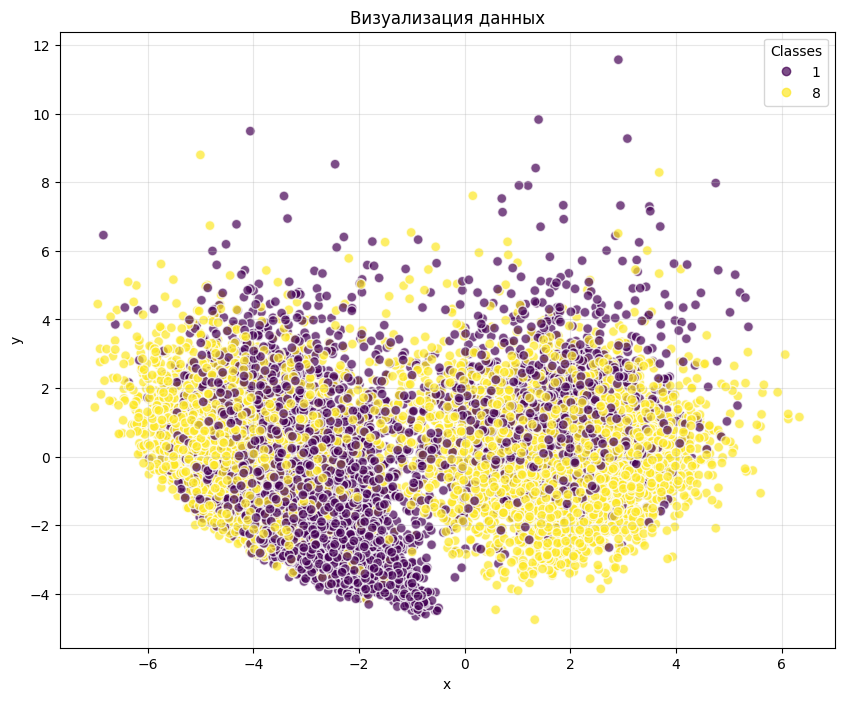

In [39]:
plt.figure(figsize=(10, 8))
mask = np.bitwise_or(y_train == 1, y_train == 8)
scatter = plt.scatter(low_dim_train[mask, 0], 
                        low_dim_train[mask, 1], 
                        c=y_train[mask], 
                        cmap='viridis',
                        alpha=0.7,
                        edgecolors='w',
                        s=50)

plt.legend(*scatter.legend_elements(), title="Classes")

plt.title("Визуализация данных")
plt.xlabel("x")
plt.ylabel("y")

plt.grid(True, alpha=0.3)
plt.show()

Можно заметить, что четкой структуры классов нет, так что они все относительно похожие. Так же можно посмотреть на примеры данных и убедиться в этом, так что в данных есть похожие классы

Для предобучения можно взять другие датасеты с символами на хирогане, обучение на них позволит выявить основные паттерны, которые используются в написании. Лучше всего такое может сработать со сверточными нейросетями, сейчас в качестве бейзлайна хочется взять KNN, так что пробовать это не будем. Еще можно применить методы оверсэмплинга. Их основная идея в построении новых объектов класса рядом с существующими. Для реализации этого существует библиотека imbalanced-learn, в которой реализованы все эти функции. В нашей задаче есть баланс классов и есть похожие, поэтому не будем генерировать новые данные, так как они могут ухудшить качество

 В качестве основной метрики будем использовать точность, так как мы хотим правильно определять символы. Если мы захотим решать задачу OCR, то основной метрикой можно будет взять CrossEnthropyLoss, так как можно будет добавить LM для исправления ошибок, но в нашей постановке мы решаем задачу для отдельных символов. В качестве дополнительных метрик рассмотрим precision, recall, f1 для каждого класса и их усреднение в качестве итогового значения, это позволит находить классы с наименьшей точностью и улучшать модель на этих классах.

Датасет уже разделен на обучающую и тестовую выборки. Если разбивать самому, то первый подход, это просто разбить стратифицированно. Второй вариант - это взять центры кластеров объектов 1 класса и разбивать стратифицированно по балансу классов и расстоянию элементов выборки от центра. Так мы сможем учитывать объекты с разной степерью похожести на средний объект класса. Для реализации нам нужно посчитать расстояния от каждого объекта до центра его кластера, бинаризовать объекты по расстоянию и из каждой группы набрать определенный процент в тестовую выборку. Для бинаризации можно использовать линейное разбиение по квантилям множества расстояний(например для разбиения на 5 групп использовать границы от 0 до 0.2 квантилей, 0.2-0.4 и так далее). Еще можно объекты одного класса приблизить гауссианой и делать разбиение по квантилям распределения(что, фактически, ядровой переход в прошлом варианте), что позволит корректнее учесть расположение объектов. Для примера сделаем стратифицированное разбиение train выборки на train/val, что пригодится при переборе гиперпараметров

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=10000, random_state=42, stratify=y_train)

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

Проверим отсутствие дубликатов

In [7]:
import pandas as pd
df = pd.DataFrame(data=x_train)
assert len(df) == len(df.drop_duplicates())

Проверим, что в данных нет пропусков. Тогда все объекты будут корректными изображениями

In [13]:
assert df.isna().any(axis=1).sum() == 0

Поскольку наши данные это рукописные символы, то мы не можем считать утечкой близкие объекты, так как в самой постановке задачи написание символов должно быть похожим. Можем только проверить полное совпадение объектов.

In [31]:
df = pd.DataFrame(data=np.vstack([x_train, x_test]))
assert len(df) == len(df.drop_duplicates())

Из преобразований данных нам нужно сделать flatten, так как мы хотим обучать KNN и нормализацию в отрезок [0, 1], так как в дальнейших методах мы захотим этим пользоваться

Добавим случайные повороты и сдвиги наших картинок, так как наш алгоритм не использует обучение батчами, то сделаем аугментации 1 раз, удвоив размер выборки. При этом получим, что качество немного выросло

In [17]:
import torch
from torchvision.transforms import v2

train_aug = v2.Compose([
    v2.RandomRotation(5),
    v2.RandomResizedCrop(size=(28, 28), scale=(0.9, 1))
])

x_train = load('kmnist-train-imgs.npz')
x_test = load('kmnist-test-imgs.npz')
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')
X_train_aug = train_aug(torch.from_numpy(x_train).unsqueeze(1)).squeeze(1).numpy()

In [23]:
x_train_aug = np.vstack([x_train, X_train_aug])
y_train_aug = np.hstack([y_train, y_train])

In [27]:
x_train_aug = x_train_aug.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

x_train_aug = x_train_aug / 255.0
x_test = x_test / 255.0

В качестве бейзлайна возьмем алгоритм KNN, так так каждый класс это отдельный рукописный символ, то можно ожидать, что объекты одного класса будут достаточно близки. При этом алгоритм максимально простой и не требует обучения, а просто ищет похожие объекты из обучающей выборки.

In [ ]:
import wandb
wandb.init(entity='andre7416', project="kmnist", name='KNN_Baseline')
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

wandb.log({
    "accuracy": accuracy,
    "classification_report": classification_report(y_test, y_pred, output_dict=True)
})
wandb.finish()

Accuracy: 0.9133
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1000
           1       0.90      0.92      0.91      1000
           2       0.83      0.88      0.85      1000
           3       0.91      0.97      0.94      1000
           4       0.95      0.88      0.91      1000
           5       0.91      0.92      0.92      1000
           6       0.90      0.95      0.92      1000
           7       0.96      0.89      0.93      1000
           8       0.86      0.94      0.90      1000
           9       0.97      0.89      0.93      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



In [ ]:
import wandb
wandb.init(entity='andre7416', project="kmnist", name='KNN_Baseline_with_aug')
knn = KNeighborsClassifier()
knn.fit(x_train_aug, y_train_aug)

y_pred = knn.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

wandb.log({
    "accuracy": accuracy,
    "classification_report": classification_report(y_test, y_pred, output_dict=True)
})
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: andre7416 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Accuracy: 0.9201
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1000
           1       0.91      0.93      0.92      1000
           2       0.86      0.89      0.88      1000
           3       0.92      0.96      0.94      1000
           4       0.97      0.87      0.91      1000
           5       0.92      0.92      0.92      1000
           6       0.90      0.95      0.93      1000
           7       0.97      0.91      0.94      1000
           8       0.86      0.95      0.90      1000
           9       0.97      0.90      0.93      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



accuracy,▁
accuracy,0.9201
